In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt, Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
plt.style.use('seaborn')

In [ ]:
# Colab에 Mecab 설치

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 5.51 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-04-17 14:31:12--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=deXhfZ

In [ ]:
!pip install konlpy

# [4월 15일]
---

## # 데이터 전처리
---

### # 데이터 로드
---

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt', filename = 'ratings_total.txt')

total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])
print('전체 리뷰 개수 :', len(total_data))

display(total_data[:5])

전체 리뷰 개수 : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### # 훈련 데이터, 테스트 데이터 분리
---

In [ ]:
# 평점이 4, 5인 리뷰에는 레이블 1, 평점이 1, 2 점인 리뷰에는 레이블 0을 부여

total_data['label'] = np.select([total_data['ratings'] > 3], [1], [0])
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 중복 샘플 제거

total_data.drop_duplicates(subset = ['reviews'], inplace = True)
print('총 샘플의 수 :', len(total_data))

총 샘플의 수 : 199908


In [ ]:
# Null 확인

total_data.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [ ]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

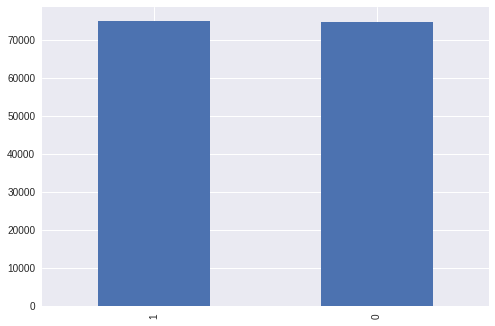

In [ ]:
# 레이블 분포 확인

train_data['label'].value_counts().plot(kind = 'bar')

### # 데이터 정제
---

In [ ]:
# 한글과 공백을 제외하고 모두 제거

train_data['reviews'] = train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex = True) # 정규표현식으로 사용 : regex = True
train_data['reviews'].replace('', np.nan, inplace = True)

test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex = True)
test_data['reviews'].replace('', np.nan, inplace = True)
test_data = test_data.dropna(how = 'any')

print(train_data.isnull().sum(), '\n')
print(test_data.isnull().sum(), '\n')

print(len(train_data), len(test_data))

ratings    0
reviews    0
label      0
dtype: int64 

ratings    0
reviews    0
label      0
dtype: int64 

149931 49977


### # 토큰화
---

In [ ]:
# konply의 Okt 함수를 사용

okt = Okt()

print(okt.morphs('와 이런 것도 요리라고 내가 만드는 게 무조건 낫다.'))

['와', '이런', '것', '도', '요리', '라고', '내', '가', '만드는', '게', '무조건', '낫다', '.']


In [ ]:
# konply의 Mecab 함수를 사용

mecab = Mecab()

print(mecab.morphs('와 이런 것도 요리라고 내가 만드는 게 무조건 낫다.'))

In [ ]:
# 불용어 지정

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
# 토큰화

train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### # 단어와 길이 분포 확인
---

In [ ]:
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)

In [ ]:
# Counter()를 사용하여 빈도수가 높은 상위 20개의 단어들을 출력

positive_word_count = Counter(positive_words)
negative_word_count = Counter(negative_words)

print(positive_word_count.most_common(20), '\n')
print(negative_word_count.most_common(20))

[('잘', 15302), ('좋아요', 14527), ('배송', 12251), ('너무', 9100), ('재구매', 8573), ('구매', 7186), ('요', 6639), ('사용', 5415), ('가격', 5015), ('으로', 4477), ('같아요', 4434), ('로', 4318), ('좋네요', 4221), ('빠르고', 4025), ('보다', 3955), ('제품', 3950), ('주문', 3815), ('입니다', 3769), ('생각', 3491), ('했어요', 3367)] 

[('너무', 13039), ('요', 11784), ('안', 11676), ('배송', 9171), ('그냥', 8518), ('잘', 7817), ('로', 5777), ('했는데', 5692), ('별로', 5549), ('못', 5174), ('제품', 5071), ('으로', 4999), ('생각', 4927), ('좀', 4878), ('사용', 4846), ('하고', 4769), ('ㅠㅠ', 4760), ('구매', 4634), ('보다', 4617), ('맛', 4017)]


긍정 리뷰의 평균 길이 : 10.768613440337008
부정 리뷰의 평균 길이 : 14.101804639739449


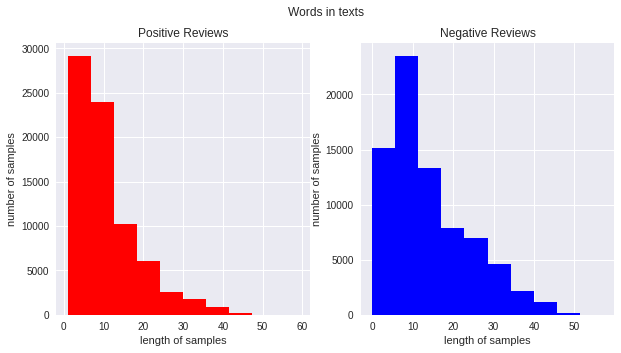

In [ ]:
# 긍정 리뷰와 부정 리뷰의 길이 분포를 시각화

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### # 정수 인코딩
---

In [ ]:
# 모델용 데이터 생성

X_train = train_data['tokenized'].values
X_test = test_data['tokenized'].values

y_train = train_data['label'].values
y_test = test_data['label'].values

In [ ]:
# 단어 집합에서 희귀 단어의 비율과 전체 등장 빈도에서 희귀 단어 등장 빈도 비율 차이가 너무 많이 나므로 인코딩 과정에서 희귀 단어는 배제

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수의 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94361
등장 빈도가 1번 이하인 희귀 단어의 수: 52344
단어 집합에서 희귀 단어의 비율: 55.47207002893144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.807755335212537


In [ ]:
tokenizer.word_index

{'잘': 1,
 '너무': 2,
 '배송': 3,
 '요': 4,
 '좋아요': 5,
 '안': 6,
 '재구매': 7,
 '구매': 8,
 '사용': 9,
 '로': 10,
 '으로': 11,
 '그냥': 12,
 '제품': 13,
 '했는데': 14,
 '가격': 15,
 '보다': 16,
 '생각': 17,
 '하고': 18,
 '같아요': 19,
 '좀': 20,
 '입니다': 21,
 '주문': 22,
 '맛': 23,
 '많이': 24,
 '더': 25,
 '못': 26,
 '때': 27,
 '해서': 28,
 '별로': 29,
 '만': 30,
 '것': 31,
 '사이즈': 32,
 'ㅠㅠ': 33,
 '포장': 34,
 '에서': 35,
 '개': 36,
 '서': 37,
 '합니다': 38,
 '거': 39,
 '상품': 40,
 '좋네요': 41,
 'ㅠ': 42,
 '빠르고': 43,
 '했어요': 44,
 '정말': 45,
 '다른': 46,
 '냄새': 47,
 '부분': 48,
 '제': 49,
 '이라': 50,
 '나': 51,
 '인데': 52,
 'ㅎㅎ': 53,
 '하나': 54,
 '넘': 55,
 '두': 56,
 '아주': 57,
 '진짜': 58,
 '좋습니다': 59,
 '샀는데': 60,
 '저': 61,
 '할': 62,
 '좋은': 63,
 '만족합니다': 64,
 '또': 65,
 '조금': 66,
 '구입': 67,
 '반품': 68,
 'ㅜㅜ': 69,
 '딱': 70,
 '아이': 71,
 '정도': 72,
 '해': 73,
 '맘': 74,
 '느낌': 75,
 '아직': 76,
 '완전': 77,
 '중': 78,
 '좋고': 79,
 '감사합니다': 80,
 '엄청': 81,
 '용': 82,
 '처음': 83,
 '면': 84,
 '있어요': 85,
 '일': 86,
 '비': 87,
 '사진': 88,
 '않고': 89,
 '디자인': 90,
 '효과': 91,
 '라': 92,
 '그': 9

In [ ]:
tokenizer.word_counts

OrderedDict([('사이즈', 5790),
             ('센치', 105),
             ('씩', 1008),
             ('늘린건데', 1),
             ('작아요', 946),
             ('그리고', 1538),
             ('색상', 2249),
             ('완전', 2841),
             ('달라', 874),
             ('요', 18423),
             ('칙칙한', 15),
             ('핑크', 356),
             ('ㅠㅠ', 5659),
             ('많이', 6604),
             ('아쉽지만', 156),
             ('암', 265),
             ('막', 730),
             ('효과', 2390),
             ('좋아요', 15601),
             ('ㅂ', 78),
             ('불만족', 175),
             ('빗', 48),
             ('아픔', 69),
             ('멍', 68),
             ('피부', 1061),
             ('빗질못', 1),
             ('해주겟네요', 1),
             ('제품', 9021),
             ('쓰고', 1837),
             ('삼일', 28),
             ('만에', 892),
             ('변기', 84),
             ('물이', 568),
             ('잘', 23119),
             ('안', 14582),
             ('내려갔어요', 2),
             ('혹시', 291),
             ('나', 3633),


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 42019


In [ ]:
# vocab_size 빈도 이하로 등장하는 단어는 자르고 정수 인코딩
# 정수 인코딩 과정에서 vocab_size보다 큰 숫자가 부여된 단어들은 OOV로 변환

tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[33, 2263, 274, 1, 294, 174, 105, 78, 328, 5, 9212, 790, 5, 34, 25, 1637, 1036, 391, 92, 6], [2867, 1494, 4132, 3159, 3194, 260, 1, 1], [14, 139, 6114, 318, 2720, 504, 2, 7, 30070, 946, 52, 29, 100, 2995, 170, 504, 100, 2, 13635, 7396, 4010, 5, 69, 18012]]


### # 패딩
---

리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.43415304373345


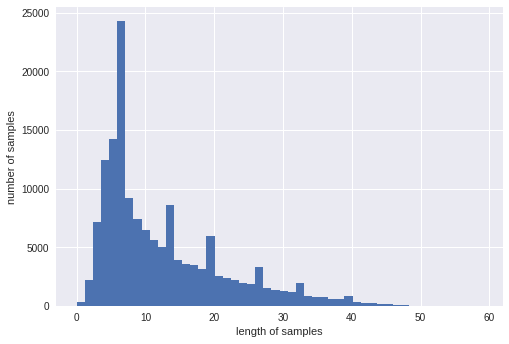

In [ ]:
# 리뷰의 길이 확인
# 그래프 상으로는 대부분 50이하의 길이를 가지는 것으로 보인다.

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 패딩 길이에 따라 몇 개의 샘플을 온전히 보전할 수 있을지 확인하는 사용자 함수
# 훈련용 리뷰를 길이 55로 패딩

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 55
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.99866605305107


## # GRU로 네이버 쇼핑 리뷰 감성 분류
---

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100 # 임베딩 벡터의 차원 (output 값)
hidden_units = 128 # Hidden State의 크기 (output 값)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

# val_loss가 증가하면 과적합 징후이므로 검증 데이터 손실이 4회 이상 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 훈련하는 동안 일정한 간격으로 모델의 체크포인트를 저장
# save_best_only : 매 에포크가 끝날때 값을 기록하지만 최종적으로는 가장 좋았던 모델만을 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) 

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 15, 
                    callbacks=[es, mc], 
                    batch_size = 64, 
                    validation_split = 0.2)

Epoch 1/15
1875/1875 [==============================] - 25s 8ms/step - loss: 0.2766 - acc: 0.8927 - val_loss: 0.2339 - val_acc: 0.9148
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2183 - acc: 0.9214 - val_loss: 0.2231 - val_acc: 0.9186
Epoch 3/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1980 - acc: 0.9299 - val_loss: 0.2231 - val_acc: 0.9197
Epoch 4/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1826 - acc: 0.9364 - val_loss: 0.2179 - val_acc: 0.9223
Epoch 5/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1704 - acc: 0.9412 - val_loss: 0.2209 - val_acc: 0.9212
Epoch 6/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1599 - acc: 0.9453 - val_loss: 0.2234 - val_acc: 0.9192
Epoch 7/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1493 - acc: 0.9490 - val_loss: 0.2303 - val_acc: 0.9194
Epoch 8/15
1875/1875 [==============================] -

1562/1562 [==============================] - 5s 3ms/step - loss: 0.2472 - acc: 0.9119


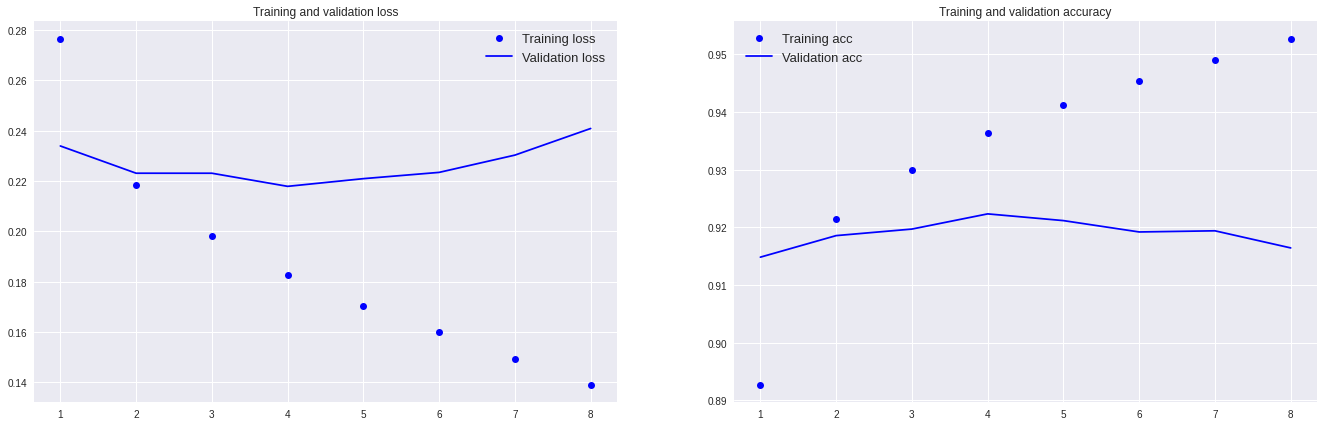

In [ ]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, y_test)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize = (23, 7))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(fontsize = 13)

fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(fontsize = 13)

plt.show()

## # 리뷰 예측
---

In [ ]:
# 리뷰 예측용 사용자 함수

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(model.predict(pad_new))
  if(score > 0.5):
    print("긍정 (정확도 : {:.2f}%)".format(score * 100))
  else:
    print("부정 (정확도 : {:.2f}%)".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')
sentiment_predict('처음 써봤는데 대박 좋아요.')
sentiment_predict('원래 배송이 이렇게 늦나요')
sentiment_predict('좋은 거 인정! 추가 구매 의향 있습니다.')
sentiment_predict('이건 정말 리뷰 쓰는 것이 아깝네요.')
sentiment_predict('오')

긍정 (정확도 : 99.30%)
부정 (정확도 : 99.86%)
긍정 (정확도 : 96.30%)
부정 (정확도 : 83.85%)
긍정 (정확도 : 97.15%)
부정 (정확도 : 93.68%)
긍정 (정확도 : 95.90%)
부정 (정확도 : 96.01%)
부정 (정확도 : 67.13%)


## # STOPWORD 참조
---

In [ ]:
stopwords = urllib.request.urlopen('https://gist.githubusercontent.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a/raw/4f7a635040442a995568270ac8156448f2d1f0cb/stopwords-ko.txt')
pd.read_table(stopwords)